# Merging In-Situ & LandSat data

In [41]:
import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

First, let's read in the data as pandas dataframes.

In [76]:
insitu = pd.read_csv('complete_in-situ.csv', low_memory=False)-
sat = pd.read_csv('larger_landsat.csv', low_memory=False)

To make them easier to work with, let's convert all columns to lowercase.

In [80]:
insitu.columns = [x.lower() for x in insitu.columns]
sat.columns = [x.lower() for x in sat.columns]

The two datasets use different datetime formats, so let's convert them to a common datetime type.

In [81]:
insitu['date'] = pd.to_datetime(insitu['date'])
sat['date'] = pd.to_datetime(sat['date'])

And let's check the number of observations in each dataset.

In [82]:
len(insitu)

23556

In [83]:
len(sat)

654306

What's the number of resulting observations if perform a simple inner join using the `date` & `comid` as merge keys?

In [84]:
df = insitu.merge(sat, on=['date', 'comid'])
len(df)

3609

What's the number of resulting observations if we allow a 1-day difference in `date`?

In [85]:
# add columns to sat that hold the date plus/minus 1 day
sat['date_plus_1'] = sat['date'] + dt.timedelta(days=1)
sat['date_minus_1'] = sat['date'] + dt.timedelta(days=-1)
# create a list to hold the individual merge results
assemble = []
# merge on equal dates
assemble.append(insitu.merge(sat, on=['date', 'comid']))
# merge on sat date is 1 day ahead of insitu date
assemble.append(insitu.merge(sat, left_on=['date', 'comid'], right_on=['date_plus_1', 'comid']))
# merge on sat date is 1 day behind insitu date
assemble.append(insitu.merge(sat, left_on=['date', 'comid'], right_on=['date_minus_1', 'comid']))
# create a new dataframe from individual merge results
df = pd.concat(assemble)
len(df)

10358

Finally, I'd like to see the distribution of the minimum time gaps of in-situ observations. For each observation, what is minimum time delta between that observation and all LandSat observations of the same lake?

In [72]:
mintimegap = insitu.apply(
    lambda x: (sat[sat['comid'] == x['comid']]['date'] - x['date']).abs().min(),
    axis=1
)

Let's make a histogram of the minimum time gaps.

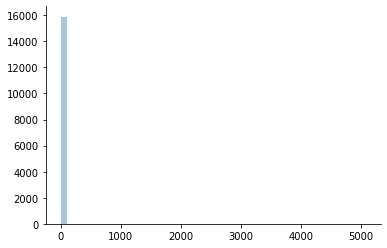

In [73]:
sb.distplot(mintimegap.dt.days.dropna(), kde=False)
sb.despine()
plt.show()

We can zoom in to a more interesting window, $<50$ days.

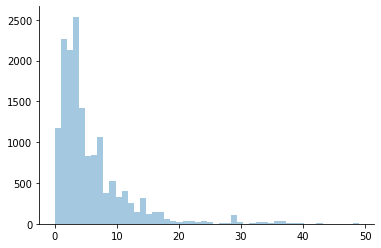

In [75]:
timegap_filtered = mintimegap.dt.days.dropna()
timegap_filtered = timegap_filtered[timegap_filtered < 50]
sb.distplot(timegap_filtered, kde=False)
sb.despine()
plt.show()